In [9]:
import torch as t
from math import pi
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

User Input

In [10]:
device = t.device('cpu')

In [11]:
n_iter = t.tensor(100000, device=device, dtype=t.int)
n_data = t.tensor(10000, device=device, dtype=t.int)
noise_amplitude = t.tensor(0.1, device=device, dtype=t.float)
learning_rate = t.tensor(1E-3, device=device, dtype=t.float)

Generatinging Training Data

In [12]:
x = t.linspace(-pi, pi, n_data, device=device, dtype=t.float)
y = t.sin(x) + noise_amplitude*t.randn(n_data).to(device)

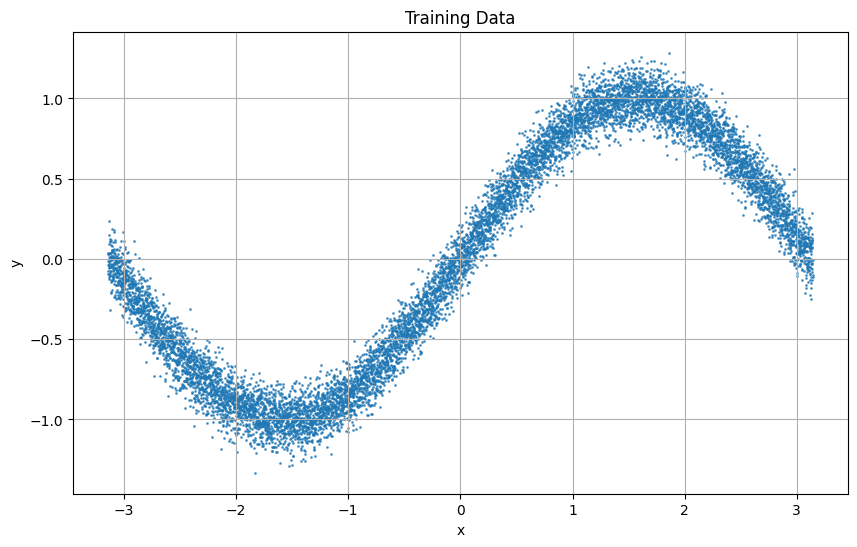

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(x.cpu(), y.cpu(), label='Noisy Sine Wave', alpha=0.7, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data')
plt.grid(True)
plt.show()

Loss Function

$
L = \frac{1}{N} \sum_{i=1}^{N} (y_{\text{pred}_i} - y_i)^2\newline
$


Gradient Calculation

$
\frac{\partial L}{\partial y_{\text{pred}}} = \frac{2}{N} \sum_{i=1}^{N} (y_{\text{pred}_i} - y_i)\newline
$

$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial y_{\text{pred}}} \times \frac{\partial y_{\text{pred}}}{\partial a} = \frac{2}{N} \sum_{i=1}^{N} (y_{\text{pred}_i} - y_i)\newline
$

$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial y_{\text{pred}}} \times \frac{\partial y_{\text{pred}}}{\partial b} = \frac{2}{N} \sum_{i=1}^{N} (y_{\text{pred}_i} - y_i) \cdot x_i\newline
$

$
\frac{\partial L}{\partial c} = \frac{\partial L}{\partial y_{\text{pred}}} \times \frac{\partial y_{\text{pred}}}{\partial c} = \frac{2}{N} \sum_{i=1}^{N} (y_{\text{pred}_i} - y_i) \cdot x_i^2\newline
$

$
\frac{\partial L}{\partial d} = \frac{\partial L}{\partial y_{\text{pred}}} \times \frac{\partial y_{\text{pred}}}{\partial c} = \frac{2}{N} \sum_{i=1}^{N} (y_{\text{pred}_i} - y_i) \cdot x_i^3\newline
$

$
\text{Updateing} ~a, ~b, ~c ~\text{and} ~d\newline
a \mathrel{-}= \text{learning\_rate} \times \frac{\partial L}{\partial a}\newline
$

$
b \mathrel{-}= \text{learning\_rate} \times \frac{\partial L}{\partial b}\newline
$

$
c \mathrel{-}= \text{learning\_rate} \times \frac{\partial L}{\partial c}\newline
$

$
d \mathrel{-}= \text{learning\_rate} \times \frac{\partial L}{\partial d}\newline
$

In [14]:
class AI_Model:
    def __init__(self) -> None:
        self.model = "a+b*x+c*x**2+d*x**3"
        self.a = t.randn((), device=device, dtype = t.float)
        self.b = t.randn((), device=device, dtype = t.float)
        self.c = t.randn((), device=device, dtype = t.float)
        self.d = t.randn((), device=device, dtype = t.float)
        self.best_a = t.randn((), device=device, dtype = t.float)
        self.best_b = t.randn((), device=device, dtype = t.float)
        self.best_c = t.randn((), device=device, dtype = t.float)
        self.best_d = t.randn((), device=device, dtype = t.float)
        self.loss = t.tensor(float('inf')).to(device)   
        self.best_loss = t.tensor(float('inf')).to(device)

    def update_best_weights(self):
        self.best_a = self.a
        self.best_b = self.b
        self.best_c = self.c
        self.best_d = self.d

    def update_best_loss(self):
        self.best_loss = self.loss

    def y_pred(self, x):
        return self.a+self.b*x+self.c*x**2+self.d*x**3
    
    def y_pred_best(self, x):
        return self.best_a + self.best_b*x + self.best_c*x**2 + self.best_d*x**3

    def get_weights(self):
        return self.a, self.b, self.c, self.d
    
    def get_best_weights(self):
        return self.best_a, self.best_b, self.best_c, self.best_d
    
    def get_model(self):
        return self.model
       

In [15]:
class plot_model:
    def __init__(self) -> None:
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        
    def plot(self, x, y_pred_best):
        self.ax.clear()
        self.ax.scatter(x.cpu(), y.cpu(), label='Noisy Sine Wave', alpha=0.7, s=1)
        self.ax.scatter(x.cpu(), y_pred_best.cpu(), label='Sine Wave From Model', color='red', alpha=0.7, s=1)
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y_pred')
        self.ax.set_title('Regression Model (3rd Order) and Training Data Plot')
        self.ax.grid(True)
        self.ax.legend()
        clear_output(wait=True)
        display(self.fig)
        # clear_output(wait=True)

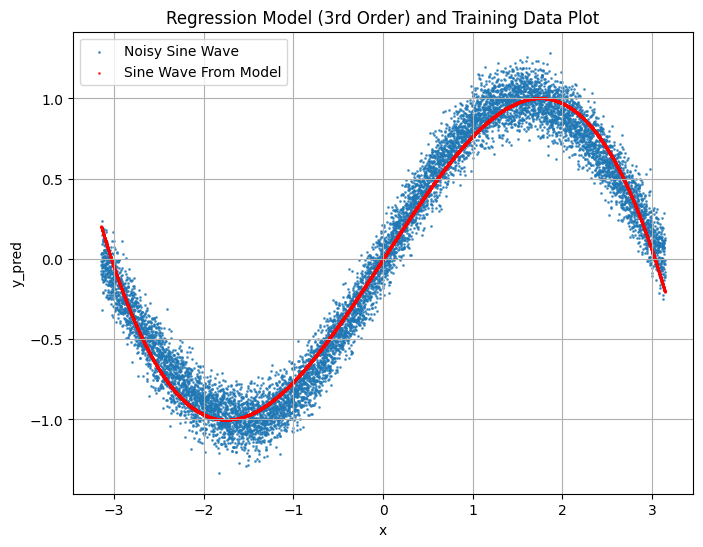


Runtime: 2.5 seconds


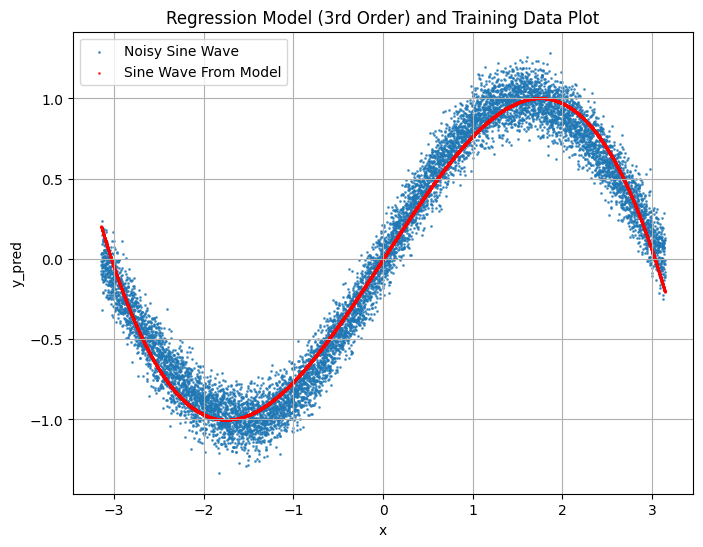

In [16]:
ai = AI_Model()
pl = plot_model()
start_time = time.time()

for i_iter in range(n_iter):
    # Forward
    y_pred = ai.y_pred(x)

    # Compute Loss
    ai.loss = t.square(y_pred - y).sum()

    # Save the weights if loss improves by 5%
    if ai.loss/ai.best_loss < 0.9999999:
        ai.update_best_loss()
        ai.update_best_weights()
        non_improving_counter = 0
    else:
        non_improving_counter += 1
        if non_improving_counter >= 10:
            print("Breaking out of the training loop.")
            break

    if i_iter % 1000 == 0:
        print(f"iteration: {i_iter} => loss: {ai.loss}")
        pl.plot(x, ai.y_pred_best(x))

    # Backprop - compute gradients weights
    delL_by_del_y_pred = 2.0*(y_pred - y)/n_data
    delL_by_del_a = delL_by_del_y_pred.sum()
    delL_by_del_b = (delL_by_del_y_pred * x).sum()
    delL_by_del_c = (delL_by_del_y_pred * x ** 2).sum()
    delL_by_del_d = (delL_by_del_y_pred * x ** 3).sum()

    # Update weights
    ai.a -= learning_rate * delL_by_del_a
    ai.b -= learning_rate * delL_by_del_b
    ai.c -= learning_rate * delL_by_del_c
    ai.d -= learning_rate * delL_by_del_d
    # ai.update_weights()

pl.plot(x, ai.y_pred_best(x))

end_time = time.time()
runtime_seconds = end_time - start_time
print(f"\nRuntime: {round(runtime_seconds, 1)} seconds")